In [1]:
#The .fit file was analysed using Jupyter Notebook, in Python 3.12.

# -------------------------------
# Step 1 : Import required libraries
# -------------------------------

# fitedecode seems better than fitparse: https://pypi.org/project/fitdecode/
import fitdecode
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter, FixedLocator
import matplotlib.ticker as mtick
import seaborn as sns
import datetime
from datetime import timedelta
import numpy as np

# -------------------------------
# Step 2 : Extract and list all message types and their fields in a FIT file
# -------------------------------
fields_by_type = defaultdict(set)

with fitdecode.FitReader("20355680594_ACTIVITY.fit") as fit:
    for frame in fit:
        if frame.frame_type == fitdecode.FIT_FRAME_DATA:
            for field in frame.fields:
                fields_by_type[frame.name].add(field.name)

data = []
for mtype, fields in fields_by_type.items():
    fields_str = ", ".join(sorted(fields))
    data.append({"message_type": mtype, "fields": fields_str})

df_fields = pd.DataFrame(data).sort_values(by="message_type").reset_index(drop=True)

# -------------------------------
# Step 3 : load FIT file and extract message types
# -------------------------------

# Utility function to extract frames of a given message type
def extract_message_type(filename, msg_type):
    """
    Extract frames of a specific message type from a FIT file and return them as a DataFrame.
    Parameters
    ----------
    filename : str
    Path to the FIT file.
    msg_type : str
    The message type (e.g., "record", "lap", "session").
    Returns
    -------
    pd.DataFrame
    Extracted records for the given message type.
    """
    records = []
    with fitdecode.FitReader(filename) as fit:
        for frame in fit:
            if frame.frame_type == fitdecode.FIT_FRAME_DATA and frame.name == msg_type:
                record = {field.name: field.value for field in frame.fields}
                records.append(record)
    return pd.DataFrame(records)

# FIT file : extract relevant messages
# Based on the information contained here: https://developer.garmin.com/fit/overview/
filename = "20355680594_ACTIVITY.fit"

df_records = extract_message_type(filename, "record")
df_lap = extract_message_type(filename, "lap")
df_user_profile = extract_message_type(filename, "user_profile")
df_event = extract_message_type(filename, "event")

# -------------------------------
# Step 4 : Retrieve weight and height from user profile
# -------------------------------
weight = df_user_profile.loc[0, 'weight']
height = df_user_profile.loc[0, 'height']
print(f"Daniel is 32 years old, weighs {weight} kg, and is {height} m tall.")

Daniel is 32 years old, weighs 60.0 kg, and is 1.78 m tall.


I do not have access to VO2 max, resting heart rate, and maximum heart rate in the data recorded by Garmin.
"To find your maximum heart rate, the most reliable formula, tested on a large number of people, is Gellish's: HRmax = 207-0.7*age" [Shookster, D., Lindsey, B., Cortes, N., & Martin, J. (2020). Accuracy of 5 common age-predicted maximal heart rate equations. International Journal of Exercise Science, 13(7), 1242‑1250. https://doi.org/10.70252/XFSJ6815]
Heart rate max estimated = 185 bpm

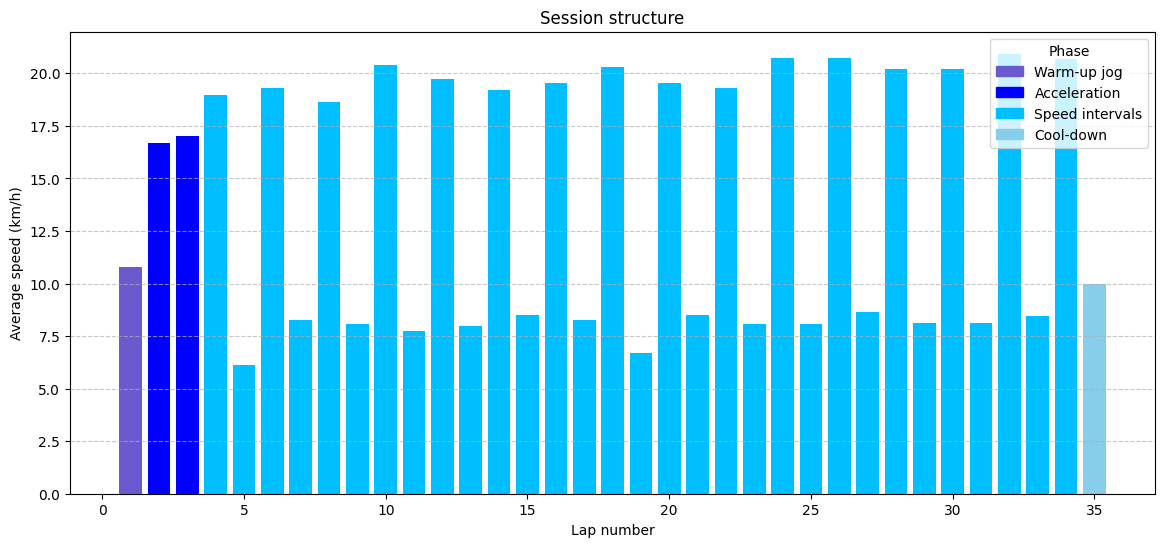

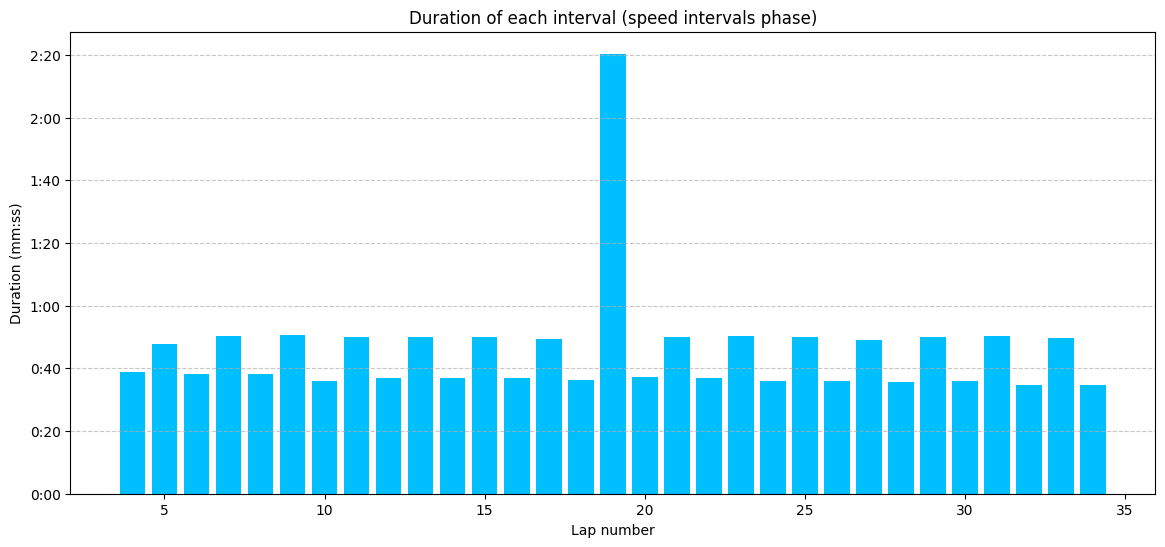

In [3]:
# -------------------------------
# Step 5: Identify the structure of the training session
# -------------------------------

# Select relevant columns from lap data
lap_cols = [
    'timestamp','start_time','total_distance','total_timer_time','avg_speed','max_speed',
    'avg_heart_rate','max_heart_rate','avg_running_cadence','max_running_cadence','avg_step_length'
]
df_lap_analysis = df_lap[lap_cols].reset_index().rename(columns={'index': 'lap_number'})
df_lap_analysis['lap_number'] += 1

# Convert speeds to km/h
df_lap_analysis['avg_speed_kmh'] = df_lap_analysis['avg_speed'] * 3.6
df_lap_analysis['max_speed_kmh'] = df_lap_analysis['max_speed'] * 3.6

# Define workout phases by lap number
def phase_from_lap(lap):
    """
    Determine the training phase based on the lap number.

    Args:
        lap (int): Lap number.

    Returns:
        str: Phase name corresponding to the lap.

    Phases:
        1      -> "Warm-up jog"
        2-3    -> "Acceleration"
        4-34   -> "Speed intervals"
        35+    -> "Cool-down"

    """
    if lap == 1:
        return "Warm-up jog"
    elif lap in [2, 3]:
        return "Acceleration"
    elif 4 <= lap <= 34:
        return "Speed intervals"
    else:
        return "Cool-down"


df_lap_analysis['phase'] = df_lap_analysis['lap_number'].apply(phase_from_lap)

# Plot session structure by average speed
colors = {"Warm-up jog": "slateblue","Acceleration": "blue","Speed intervals": "deepskyblue","Cool-down": "skyblue"}

plt.figure(figsize=(14,6))
plt.bar(df_lap_analysis["lap_number"], df_lap_analysis["avg_speed_kmh"],
        color=df_lap_analysis["phase"].map(colors))
plt.xlabel("Lap number")
plt.ylabel("Average speed (km/h)")
plt.title("Session structure")
plt.grid(axis="y", linestyle="--", alpha=0.7)
patches = [mpatches.Patch(color=col, label=phase) for phase, col in colors.items()]
plt.legend(handles=patches, title="Phase")
plt.show()

# Plot durations of interval laps (Speed intervals phase)
interval_laps = df_lap_analysis[df_lap_analysis['phase'] == "Speed intervals"].copy()

# Convert seconds into "M:SS" format
def seconds_to_mmss(x, pos=None):
    """
    Convert a duration in seconds to a string formatted as "M:SS".

    Args:
        x (int or float): Duration in seconds.
        pos (int, optional): Required by matplotlib's FuncFormatter, ignored here.

    Returns:
        str: Time formatted as "M:SS".

    """
    m, s = divmod(int(x), 60)
    return f"{m}:{s:02d}"

plt.figure(figsize=(14,6))
plt.bar(interval_laps["lap_number"], interval_laps["total_timer_time"], color="deepskyblue")
plt.xlabel("Lap number")
plt.ylabel("Duration (mm:ss)")
plt.title("Duration of each interval (speed intervals phase)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(seconds_to_mmss))
plt.show()



This step allows me to identify the structure of the session and see the type of session that was conducted.
I am assuming here that the first two speed peaks correspond to two accelerations, which is fairly typical at the end of a warm-up before starting an interval training session.

   lap_number            phase duration_hms cum_duration_hms  total_distance  \
0           1      Warm-up jog      0:25:57          0:25:57         4654.82   
1           2     Acceleration      0:00:27          0:26:24          128.69   
2           3     Acceleration      0:00:26          0:26:50          123.11   
3           4  Speed intervals      0:00:38          0:27:29          204.60   
4           5  Speed intervals      0:00:47          0:28:17           81.35   
5           6  Speed intervals      0:00:38          0:28:55          204.72   
6           7  Speed intervals      0:00:50          0:29:45          115.50   
7           8  Speed intervals      0:00:38          0:30:23          197.80   
8           9  Speed intervals      0:00:50          0:31:14          114.01   
9          10  Speed intervals      0:00:35          0:31:50          202.88   
10         11  Speed intervals      0:00:50          0:32:40          107.58   
11         12  Speed intervals      0:00

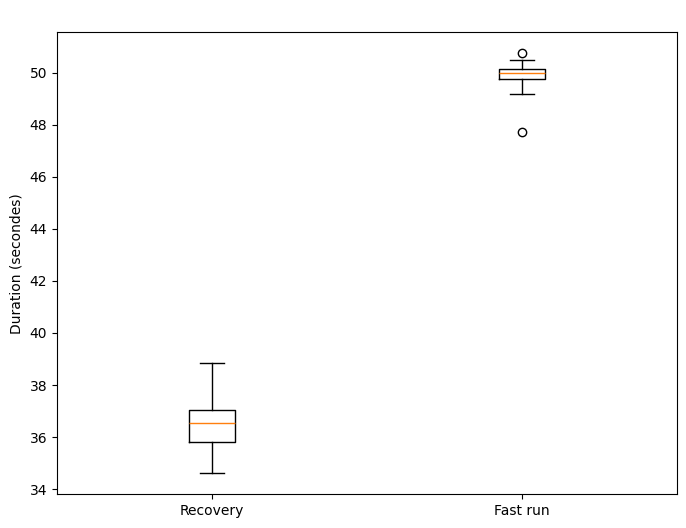

In [5]:
# Helper function to format running pace values (min/km) into "M:SS" strings
def format_pace(x):
    """
    Convert a numeric pace value (in minutes per kilometer) 
    into a formatted string "M:SS".
    """
    if np.isnan(x):
        return None
    minutes, seconds = divmod(int(round(x * 60)), 60)
    return f"{minutes}:{seconds:02d}"


# Compute cumulative stats and pace
df_lap_analysis["duration_hms"] = df_lap_analysis["total_timer_time"].apply(lambda x: str(timedelta(seconds=int(x))))
df_lap_analysis["cum_duration_sec"] = df_lap_analysis["total_timer_time"].cumsum()
df_lap_analysis["cum_duration_hms"] = df_lap_analysis["cum_duration_sec"].apply(lambda x: str(timedelta(seconds=int(x))))
df_lap_analysis["cum_distance"] = df_lap_analysis["total_distance"].cumsum()
df_lap_analysis["pace_min_per_km"] = 60 / df_lap_analysis["avg_speed_kmh"]
df_lap_analysis["pace_mmss"] = df_lap_analysis["pace_min_per_km"].apply(format_pace)


df_lap_analysis["avg_running_cadence"] = df_lap_analysis["avg_running_cadence"]*2

# Add summary row
summary = {
    "lap_number": "Summary",
    "phase": "",
    "total_timer_time": df_lap_analysis["total_timer_time"].sum(),
    "cum_distance": df_lap_analysis["total_distance"].sum(),
    "total_distance": df_lap_analysis["total_distance"].sum(),
    "avg_speed_kmh": " ",
    "avg_heart_rate": df_lap_analysis["avg_heart_rate"].mean(),
    "duration_hms": str(timedelta(seconds=int(df_lap_analysis["total_timer_time"].sum()))),
    "cum_duration_sec": df_lap_analysis["cum_duration_sec"].max(),
    "cum_duration_hms": str(timedelta(seconds=int(df_lap_analysis["cum_duration_sec"].max()))),
    "pace_mmss": df_lap_analysis["pace_min_per_km"].mean()
}
df_lap_analysis_summary = pd.concat([df_lap_analysis, pd.DataFrame([summary])], ignore_index=True)

# Display key columns
display_cols = ["lap_number","phase","duration_hms","cum_duration_hms","total_distance",
                "cum_distance","avg_speed_kmh","pace_mmss","avg_heart_rate"]
print(df_lap_analysis_summary[display_cols])

# Session summary
total_time_sec = summary["total_timer_time"]
total_distance_km = summary["total_distance"] / 1000
warmup_time_sec = df_lap_analysis.loc[df_lap_analysis["lap_number"] == 1, "total_timer_time"].values[0]
cooldown_time_sec = df_lap_analysis.loc[df_lap_analysis["phase"] == "Cool-down", "total_timer_time"].values[0]
interval_time_sec = df_lap_analysis.loc[df_lap_analysis["phase"] == "Speed intervals", "total_timer_time"].sum()

print(f"Daniel ran for {str(timedelta(seconds=int(total_time_sec)))} "
      f"and covered {total_distance_km:.2f} km. Warm-up lasted {str(timedelta(seconds=int(warmup_time_sec)))}, "
      f"speed intervals lasted {str(timedelta(seconds=int(interval_time_sec)))}, "
      f"and cool-down lasted {str(timedelta(seconds=int(cooldown_time_sec)))}.")

# Analyze odd/even interval laps and compute average durations
laps_numeric = df_lap_analysis[pd.to_numeric(df_lap_analysis["lap_number"], errors='coerce').notna()].copy()
laps_numeric["lap_number"] = laps_numeric["lap_number"].astype(int)

# Convert seconds into a "HH:MM:SS" string
def sec_to_hms(seconds):
    """
    Convert a duration in seconds to a string formatted as "HH:MM:SS".

    Args:
        seconds (int or float): Duration in seconds.

    Returns:
        str: Time formatted as "HH:MM:SS".
    """
    return str(timedelta(seconds=int(seconds)))

# Compute the average duration of laps and return as "HH:MM:SS"
def average_duration(laps_df):
    """
    Calculate the average total duration of laps from a DataFrame 
    and return it as a formatted string "HH:MM:SS".

    Args:
        laps_df (pd.DataFrame): DataFrame containing a column
                                "total_timer_time" with lap durations in seconds.

    Returns:
        str: Average duration formatted as "HH:MM:SS".

    """
    avg_sec = laps_df["total_timer_time"].mean()
    return sec_to_hms(avg_sec)

# Fast runs: even laps 4-34
fast_laps = laps_numeric.query("4 <= lap_number <= 34 and lap_number % 2 == 0").copy()
fast_laps["duration_hms"] = fast_laps["total_timer_time"].apply(sec_to_hms)
fast_avg_duration = average_duration(fast_laps)
fast_avg_distance = fast_laps["total_distance"].mean()

# Slow runs: odd laps 5-17 or 21-33
slow_laps = laps_numeric.query("((5 <= lap_number <= 17) or (21 <= lap_number <= 33)) and lap_number % 2 == 1").copy()
slow_laps["duration_hms"] = slow_laps["total_timer_time"].apply(sec_to_hms)
slow_avg_duration = average_duration(slow_laps)
slow_avg_distance = slow_laps["total_distance"].mean()

print(f"\nAverage duration of fast run: {fast_avg_duration}")
print(f"\nAverage duration of recovery : {slow_avg_duration}")
print(f"\nAverage duration of fast run: {fast_avg_distance}")
print(f"\nAverage duration of recovery : {slow_avg_distance}")

###
plt.figure(figsize=(8, 6))

plt.boxplot([fast_laps["total_timer_time"], slow_laps["total_timer_time"]],
            tick_labels=["Recovery", "Fast run"])

plt.ylabel("Duration (secondes)")
plt.title(" ")
plt.show()


This step allows me to identify more precisely each fast interval and each slow interval. I wonder about the ratio: perhaps the session should be alternating between 200 metres fast and 100 metres slow? 

What we can say for certain: 
Daniel did two sets of eight repetitions in a speed/fast format with a two-minute, 20-second rest period between sets.

In [7]:
# --------------------------
# Step 6 : Record analysis
# --------------------------

# --- Copy the dataframe and keep only the useful columns ---
df_records_analysis = df_records[["timestamp", "distance", "speed", "step_length", "heart_rate", "cadence", "stance_time", "stance_time_balance"]].copy()

# Others metrics
df_records_analysis['speed_kmh'] = df_records_analysis['speed'] * 3.6
df_records_analysis["pace_min_per_km"] = 60 / df_records_analysis["speed_kmh"]
df_records_analysis['pace_min_per_km'] = df_records_analysis['pace_min_per_km'].replace([np.inf, -np.inf], np.nan)

df_records_analysis["pace_mmss"] = df_records_analysis["pace_min_per_km"].apply(format_pace)

#Cadence *2 (step/min)
df_records_analysis['cadence'] = df_records_analysis['cadence']*2

# Convert timestamp
df_records_analysis['timestamp_convert'] = pd.to_datetime(df_records_analysis['timestamp'])
df_records_analysis = df_records_analysis.sort_values('timestamp_convert').reset_index(drop=True)


# --- Identify active periods robustly ---
df_event['timestamp'] = pd.to_datetime(df_event['timestamp'])
active_periods = []
active_start = None

for idx, row in df_event.iterrows():
    etype = str(row['event_type']).lower()
    event = str(row.get('event','')).lower()
    if etype in ['start'] or (etype=='timer' and event=='start'):
        if not active_start:
            active_start = row['timestamp']
    elif etype in ['stop_all'] or (etype=='timer' and event=='stop'):
        if active_start:
            active_periods.append((active_start, row['timestamp']))
            active_start = None

# --- Compute cumulative moving time ---
df_records_analysis['time_moving_sec'] = 0
cumulative_time = 0

for i in range(1, len(df_records_analysis)):
    t_prev = df_records_analysis.at[i-1, 'timestamp_convert']
    t_curr = df_records_analysis.at[i, 'timestamp_convert']
    delta_sec = (t_curr - t_prev).total_seconds()

    # Check if the previous record is within an active period
    active = any(start <= t_prev < end for start, end in active_periods)

    if active:
        cumulative_time += delta_sec

    df_records_analysis.at[i, 'time_moving_sec'] = cumulative_time

df_records_analysis['time_moving_hms'] = df_records_analysis['time_moving_sec'].apply(
    lambda x: str(datetime.timedelta(seconds=int(x)))
)

# --- Function HH:MM:SS for x-axis ---
def sec_to_hhmmss(x, pos=None):
    """
    Convert a time value in seconds into a string formatted as "HH:MM:SS".

    Args:
        x (float or int): Time in seconds.
        pos (int, optional): Required by matplotlib's FuncFormatter, ignored here.

    Returns:
        str: Time formatted as "HH:MM:SS".

    """
    h = int(x // 3600)
    m = int((x % 3600) // 60)
    s = int(x % 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

# --- Prepare df_plot for plotting ---
df_plot_records = df_records_analysis.copy()
df_plot_lap = df_lap_analysis.copy()

df_intervals = df_plot_lap.loc[3:33].copy()
df_intervals['type'] = ['Fast run' if i % 2 == 1 else 'Recovery' for i in df_intervals.index]
df_intervals = df_intervals.reset_index(drop=True)
xmin, xmax = (df_intervals.index).min(), (df_intervals.index + 1).max()

palette = {'Fast run': 'blue', 'Recovery': 'skyblue'}

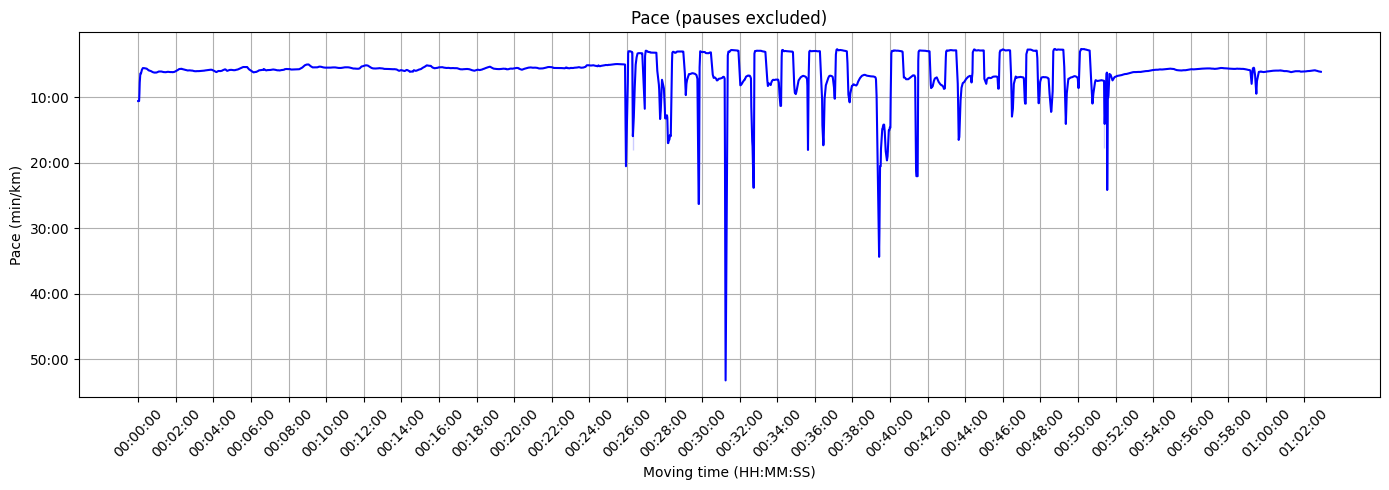

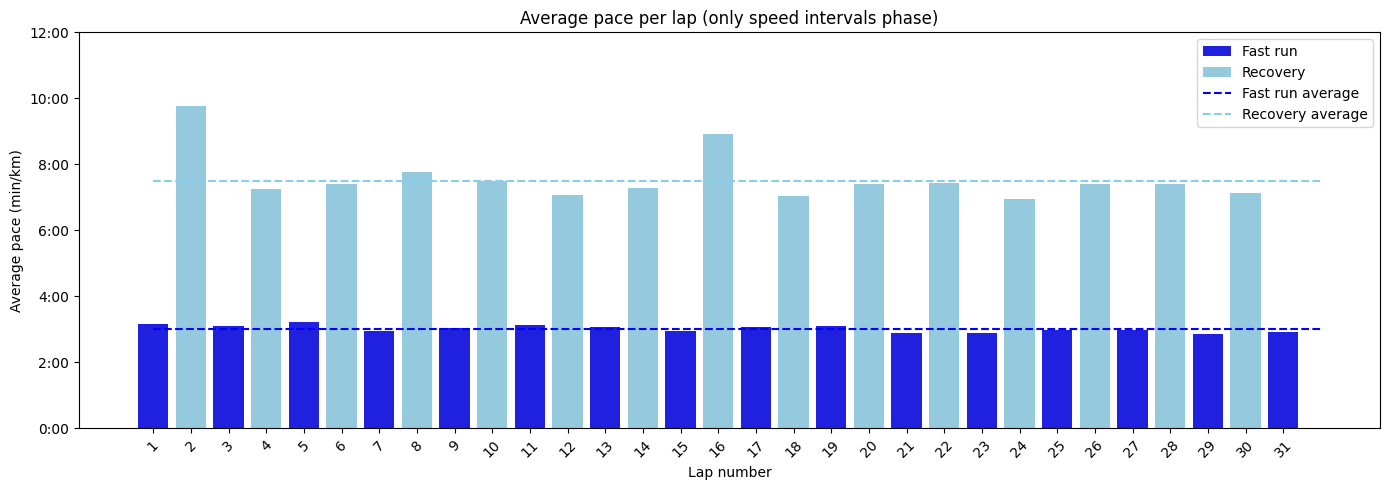

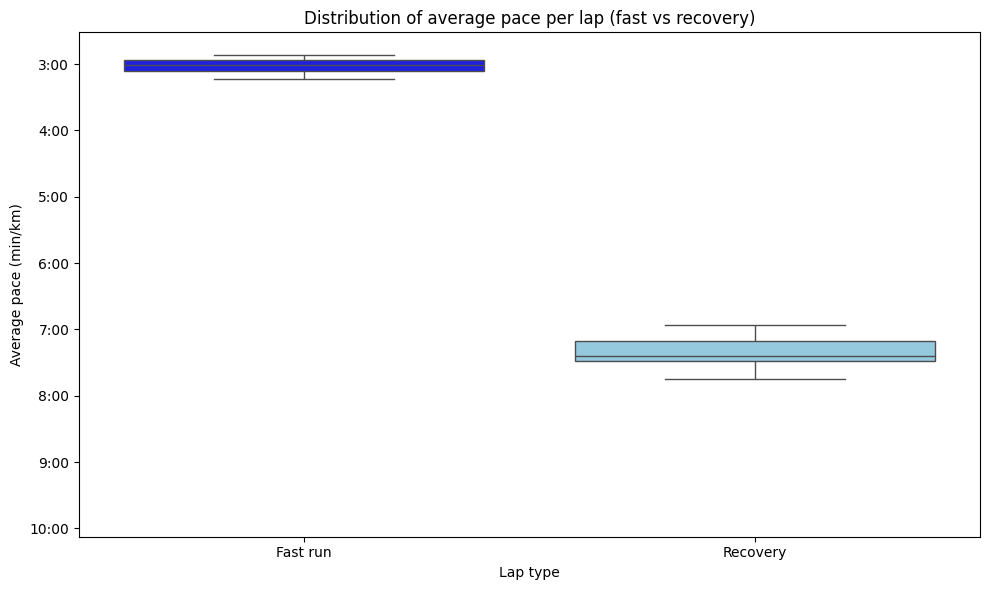

In [8]:
#Pace

# -----------------------
# --- Lineplot ---
# -----------------------
plt.figure(figsize=(14,5))
ax = plt.gca()

sns.lineplot(x='time_moving_sec', y='pace_min_per_km', 
             data=df_plot_records, color='blue')

start = df_plot_records['time_moving_sec'].min()
end = df_plot_records['time_moving_sec'].max()
ticks = np.arange(start, end + 1, 120)
ax.xaxis.set_major_locator(FixedLocator(ticks))
ax.xaxis.set_major_formatter(FuncFormatter(sec_to_hhmmss))

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: format_pace(y)))
ax.invert_yaxis()

plt.xlabel("Moving time (HH:MM:SS)")
plt.ylabel("Pace (min/km)")
plt.title("Pace (pauses excluded)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------
# --- Barplot per lap ---
# -----------------------
plt.figure(figsize=(14,5))
ax = plt.gca()

sns.barplot(x=df_intervals.index + 1, 
            y='pace_min_per_km', 
            hue='type', 
            data=df_intervals, 
            palette=palette,
            dodge=False)

fast_avg_pace = fast_laps['pace_min_per_km'].mean() 
slow_avg_pace = slow_laps['pace_min_per_km'].mean() 

ax.hlines(fast_avg_pace, xmin=xmin, xmax=xmax, colors='blue', linestyles='--', label='Fast run average')
ax.hlines(slow_avg_pace, xmin=xmin, xmax=xmax, colors='skyblue', linestyles='--', label='Recovery average')

plt.xlabel("Lap number")
plt.ylabel("Average pace (min/km)")
plt.title("Average pace per lap (only speed intervals phase)")
plt.xticks(rotation=45)
plt.legend()

yticks = ax.get_yticks()
ax.set_yticks(yticks)  
ytick_labels = [format_pace(y) if not np.isnan(y) else "" for y in yticks]
ax.set_yticklabels(ytick_labels)

plt.tight_layout()
plt.show()


# -----------------------
# --- Boxplot per type ---
# -----------------------
plt.figure(figsize=(10,6))
ax = plt.gca()

sns.boxplot(x='type', y='pace_min_per_km', 
            data=df_intervals, hue='type',
            palette=palette, dodge=False, fliersize=0)

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: format_pace(y)))

ax.invert_yaxis()

plt.xlabel("Lap type")
plt.ylabel("Average pace (min/km)")
plt.title("Distribution of average pace per lap (fast vs recovery)")
plt.legend([],[], frameon=False) 
plt.tight_layout()
plt.show()


**Analysis**
- There is a marked difference in pace between fast intervals and recovery intervals. No drift is visible (first graph).
- Average pace per lap during fast intervals appears stable (between 3:00 min/km and 3:13 min/km, on average), with no drop in pace at the end of the session.
- Average pace per lap during recovery intervals is more variable (between 6:56 min/km and 9:47 min/km, on average).

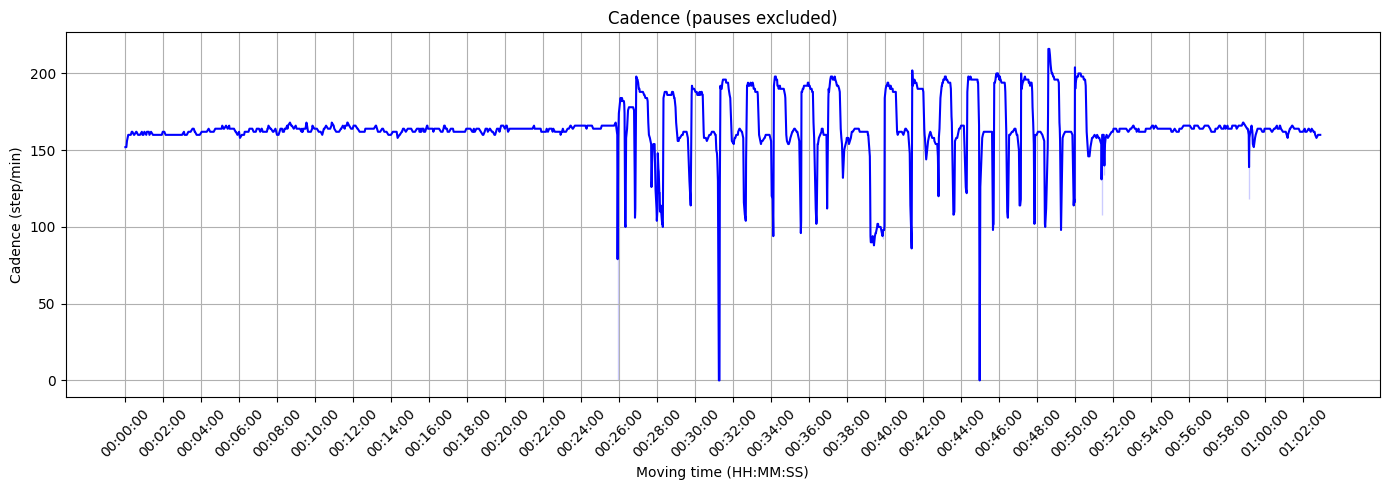

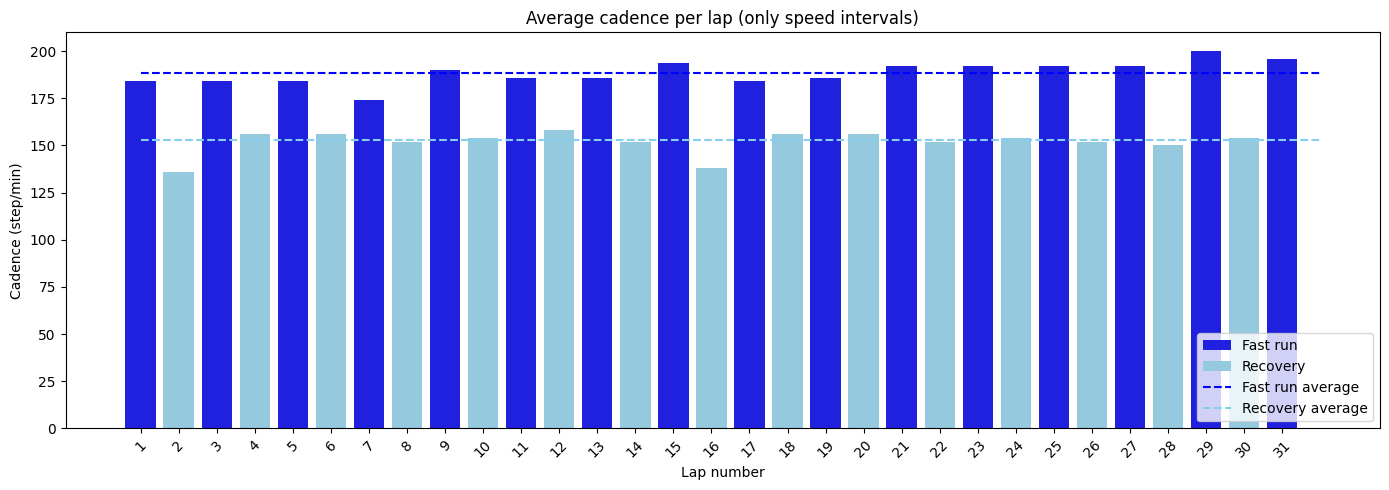

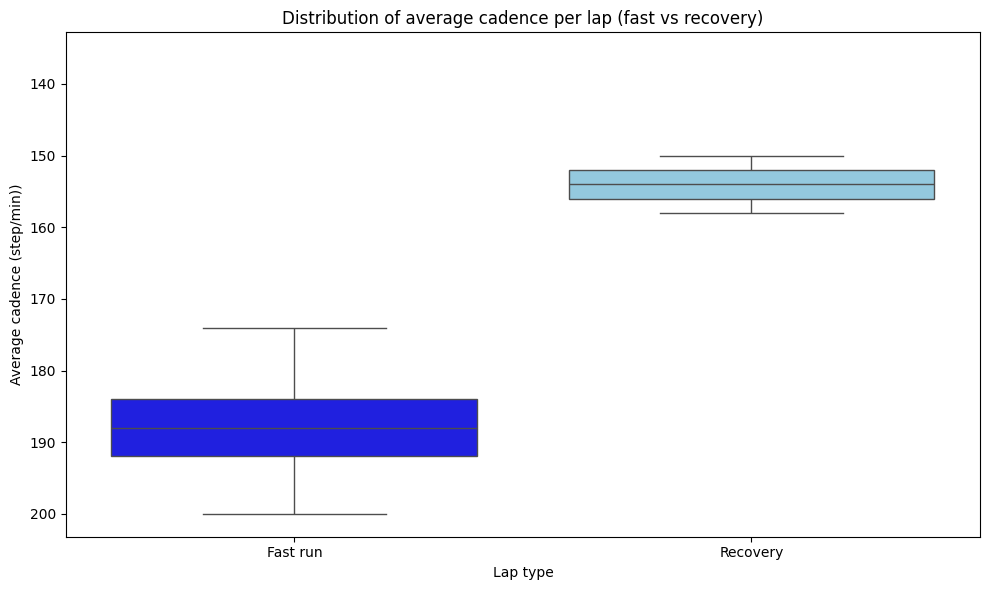

In [10]:
# Cadence (step/min)

# -----------------------
# --- Lineplot ---
# -----------------------
plt.figure(figsize=(14,5))
ax = plt.gca()

sns.lineplot(x='time_moving_sec', y="cadence", data=df_plot_records, color='blue')

start = df_plot_records['time_moving_sec'].min()
end = df_plot_records['time_moving_sec'].max()
ticks = np.arange(start, end + 1, 120)
ax.xaxis.set_major_locator(FixedLocator(ticks))
ax.xaxis.set_major_formatter(FuncFormatter(sec_to_hhmmss))

plt.xlabel("Moving time (HH:MM:SS)")
plt.ylabel("Cadence (step/min)")
plt.title("Cadence (pauses excluded)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

# -----------------------
# --- Barplot per lap ---
# -----------------------
plt.figure(figsize=(14,5))
ax = plt.gca()

sns.barplot(x=df_intervals.index + 1, 
            y='avg_running_cadence', 
            hue='type', 
            data=df_intervals, 
            palette=palette,
            dodge=False)

fast_avg_cadence = fast_laps['avg_running_cadence'].mean() 
slow_avg_cadence = slow_laps['avg_running_cadence'].mean() 

ax.hlines(fast_avg_cadence, xmin=xmin, xmax=xmax, 
          colors='blue', linestyles='--', label='Fast run average')
ax.hlines(slow_avg_cadence, xmin=xmin, xmax=xmax, 
          colors='skyblue', linestyles='--', label='Recovery average')

plt.xlabel("Lap number")
plt.ylabel("Cadence (step/min)")
plt.title("Average cadence per lap (only speed intervals)")
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# -----------------------
# --- Boxplot per type ---
# -----------------------
plt.figure(figsize=(10,6))
ax = plt.gca()

sns.boxplot(x='type', y='avg_running_cadence', data=df_intervals,
            hue='type', palette=palette, dodge=False, fliersize=0)

ax.invert_yaxis()

plt.xlabel("Lap type")
plt.ylabel("Average cadence (step/min))")
plt.title("Distribution of average cadence per lap (fast vs recovery)")
plt.legend([],[], frameon=False) 
plt.tight_layout()
plt.show()


**Analysis**
- There is a marked difference in cadence between fast intervals and recovery intervals. No drift is visible (first graph)
- Average cadence per lap during fast intervals appears variable (between 174 step/min and 200 step/min), with no drop in cadence at the end of the session but some peaks
- Average cadence per lap during recovery intervals is more stable (between 136 step/min and 156 step/min). Please note that lap number 16 corresponds to a longer recovery period between the two sets.

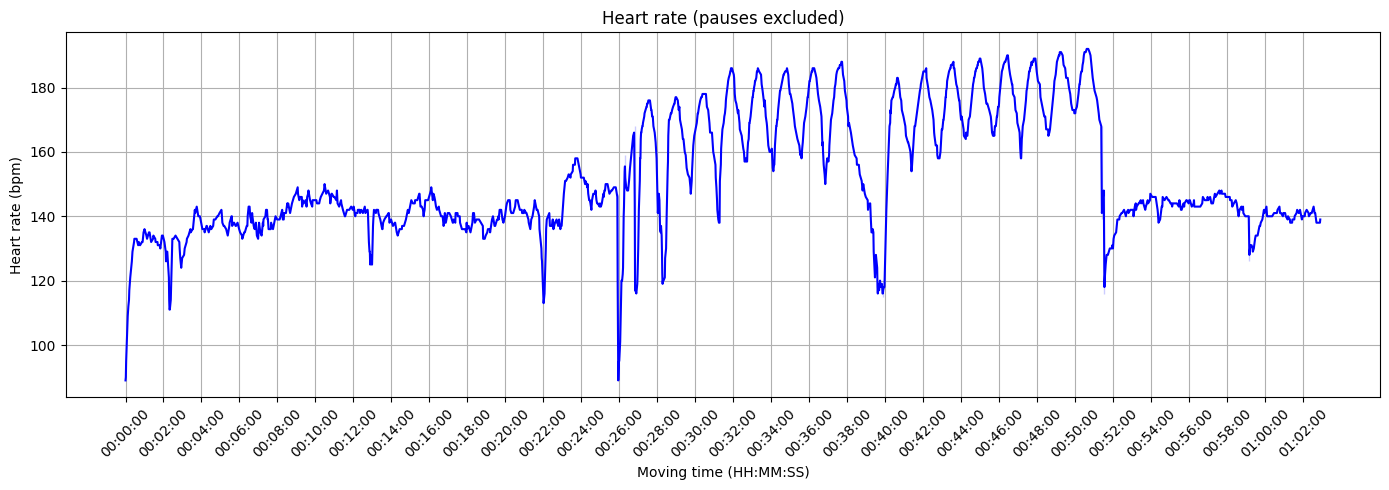

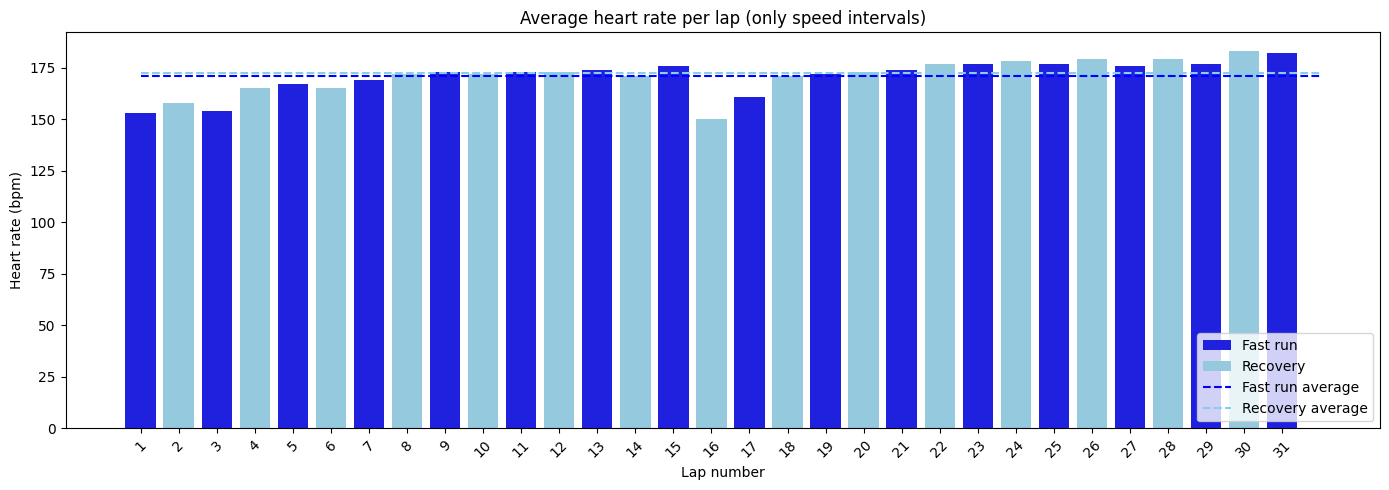

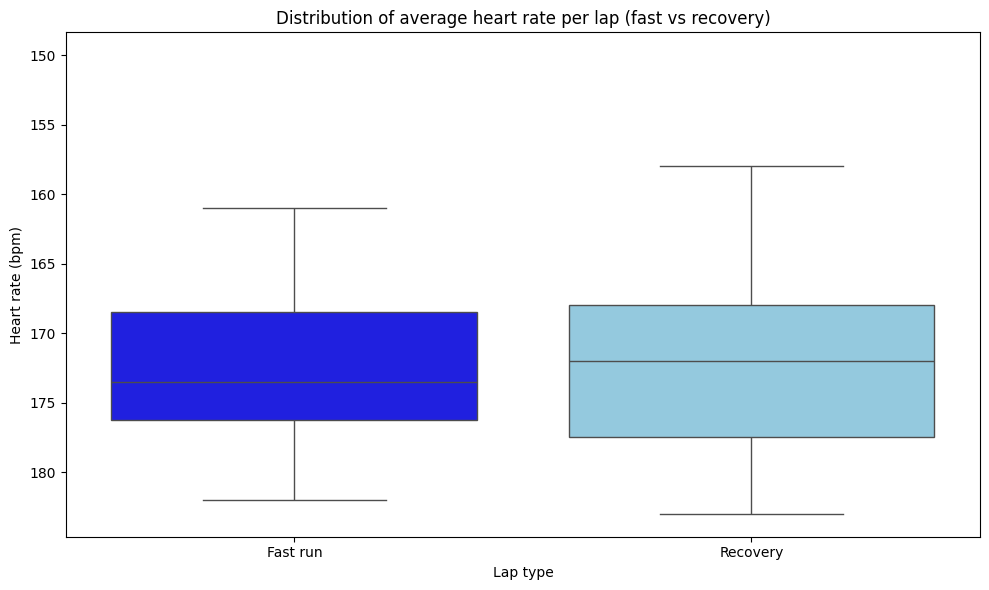

In [12]:
#Heart rate

# -----------------------
# --- Lineplot ---
# -----------------------
plt.figure(figsize=(14,5))
ax = plt.gca()

sns.lineplot(x='time_moving_sec', y="heart_rate", data=df_plot_records, color='blue')

start = df_plot_records['time_moving_sec'].min()
end = df_plot_records['time_moving_sec'].max()
ticks = np.arange(start, end + 1, 120)
ax.xaxis.set_major_locator(FixedLocator(ticks))
ax.xaxis.set_major_formatter(FuncFormatter(sec_to_hhmmss))

plt.xlabel("Moving time (HH:MM:SS)")
plt.ylabel("Heart rate (bpm)")
plt.title("Heart rate (pauses excluded)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

# -----------------------
# --- Barplot per lap ---
# -----------------------
plt.figure(figsize=(14,5))
ax = plt.gca()

sns.barplot(x=df_intervals.index + 1, 
            y='avg_heart_rate', 
            hue='type', 
            data=df_intervals, 
            palette=palette,
            dodge=False)

fast_avg_heart_rate = fast_laps['avg_heart_rate'].mean() 
slow_avg_heart_rate = slow_laps['avg_heart_rate'].mean() 

ax.hlines(fast_avg_heart_rate, xmin=xmin, xmax=xmax, 
          colors='blue', linestyles='--', label='Fast run average')
ax.hlines(slow_avg_heart_rate, xmin=xmin, xmax=xmax, 
          colors='skyblue', linestyles='--', label='Recovery average')

plt.xlabel("Lap number")
plt.ylabel("Heart rate (bpm)")
plt.title("Average heart rate per lap (only speed intervals)")
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# -----------------------
# --- Boxplot per type ---
# -----------------------
plt.figure(figsize=(10,6))
ax = plt.gca()

sns.boxplot(x='type', y='avg_heart_rate', data=df_intervals,
            hue='type', palette=palette, dodge=False, fliersize=0)

ax.invert_yaxis()

plt.xlabel("Lap type")
plt.ylabel("Heart rate (bpm)")
plt.title("Distribution of average heart rate per lap (fast vs recovery)")
plt.legend([],[], frameon=False) 
plt.tight_layout()
plt.show()

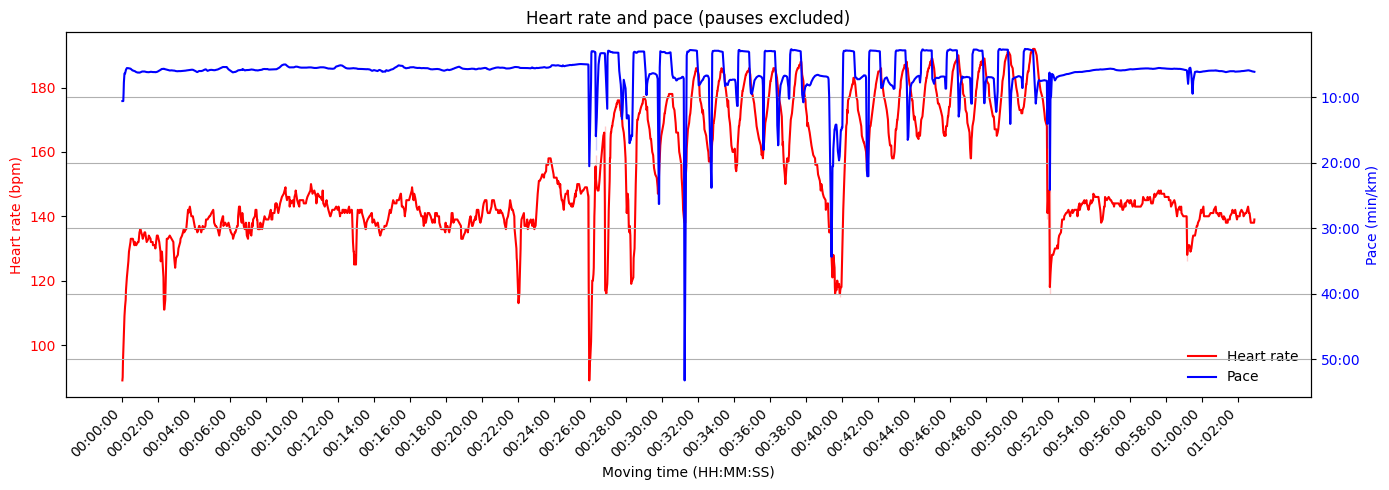

In [13]:
#Heart rate and pace
fig, ax1 = plt.subplots(figsize=(14,5))

sns.lineplot(
    x='time_moving_sec', y="heart_rate", data=df_plot_records,
    color='red', ax=ax1, legend=False, label="Heart rate"
)

start = df_plot_records['time_moving_sec'].min()
end = df_plot_records['time_moving_sec'].max()
ticks = np.arange(start, end + 1, 120)

ax1.xaxis.set_major_locator(FixedLocator(ticks))
ax1.xaxis.set_major_formatter(FuncFormatter(sec_to_hhmmss))

ax1.set_xlabel("Moving time (HH:MM:SS)")
ax1.set_ylabel("Heart rate (bpm)", color="red")
ax1.tick_params(axis='y', labelcolor="red")

ax2 = ax1.twinx()
sns.lineplot(
    x='time_moving_sec', y='pace_min_per_km',
    data=df_plot_records, color='blue', ax=ax2, legend=False, label="Pace"
)

ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: format_pace(y)))
ax2.invert_yaxis()
ax2.set_ylabel("Pace (min/km)", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")

lines1, labels1 = ax1.get_lines(), ["Heart rate"]
lines2, labels2 = ax2.get_lines(), ["Pace"]
ax1.legend(
    lines1 + lines2, labels1 + labels2,
    loc="lower right",
    ncol=1, frameon=False
)

plt.title("Heart rate and pace (pauses excluded)")
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")  # rotation des heures
plt.grid(True)
plt.tight_layout()
plt.show()


**Analysis**
- There is a marked difference in heart rate between fast intervals and recovery intervals. A slight drift in heart rate (increase in the second half of the session) is visible (first graph).
- Average heart rate per lap during fast intervals appears variable (between 153 bpm and 182 bpm) : there is a slight upward trend between the beginning of each series and the end of each series.
- Average heart race per lap during recovery intervals appears variable (between 158 bpm and 183 bmp) : it is strange to note that the averages between fast intervals and slow intervals are quite similar: either the lap measurements are inaccurate, or this may be a sign of a recovery time that is too short or a recovery capacity that could be improved.

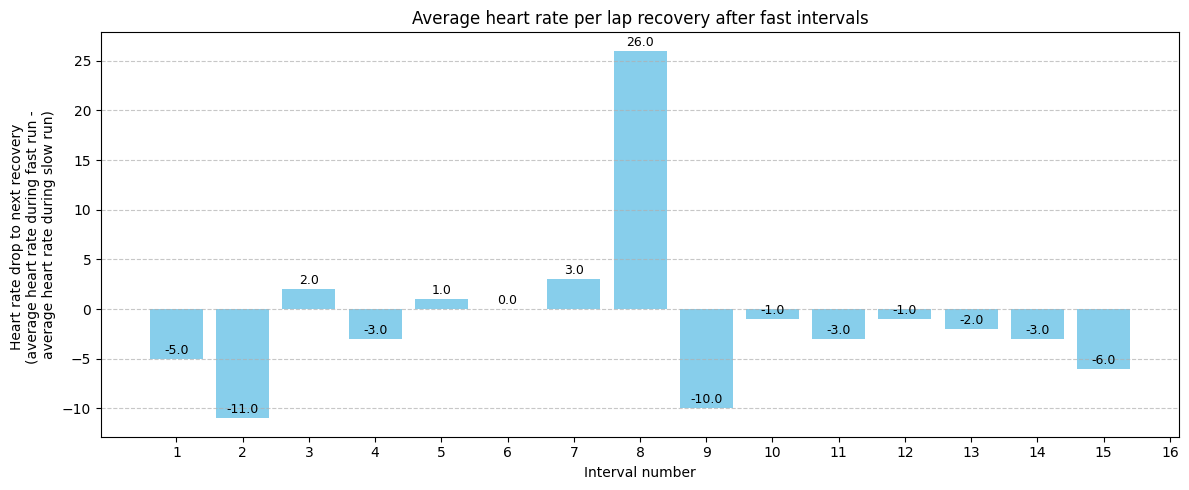

In [15]:
hr_drop = []

hr_drop = []

for i in range(0, len(df_intervals), 2):
    hr_effort = df_intervals.iloc[i]['avg_heart_rate']
    if i+1 < len(df_intervals):
        hr_recovery = df_intervals.iloc[i+1]['avg_heart_rate'] 
        hr_drop.append(hr_effort - hr_recovery) 
    else:
        hr_drop.append(np.nan)
        
plt.figure(figsize=(12,5))
x_vals = range(1, len(hr_drop)+1)
plt.bar(x_vals, hr_drop, color='skyblue')

for x, y in zip(x_vals, hr_drop):
    if not np.isnan(y):
        plt.text(x, y + 0.2, f"{y:.1f}", ha='center', va='bottom', fontsize=9)

plt.xlabel("Interval number")
plt.ylabel("Heart rate drop to next recovery \n(average heart rate during fast run - \naverage heart rate during slow run)")
plt.title("Average heart rate per lap recovery after fast intervals")
plt.xticks(x_vals)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Analysis**
After most fast phases, Daniel sees his heart rate (on average) increase further during the recovery phase (note: are the phases clearly defined and identified? Are the measurements correct?)

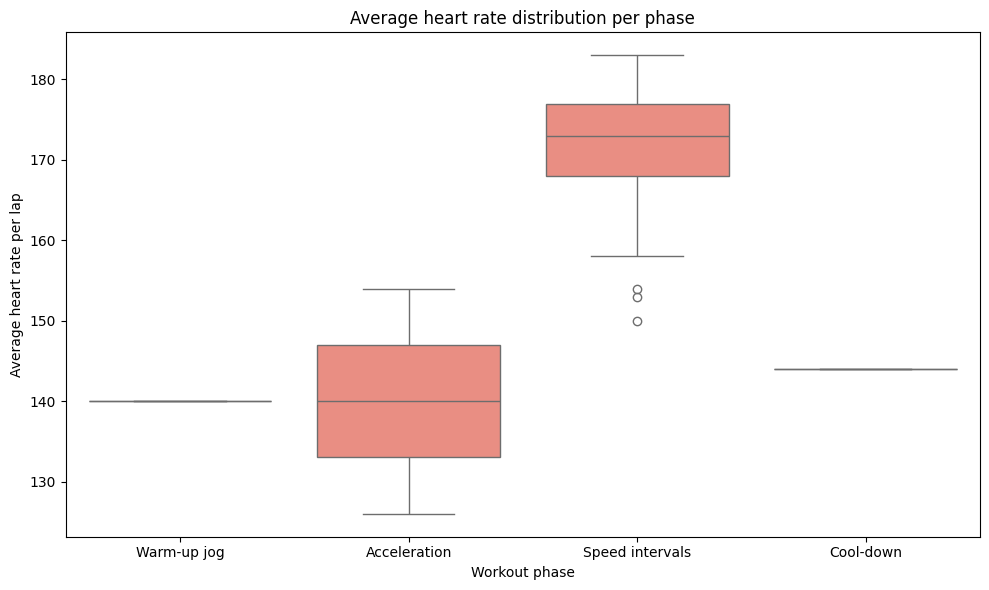

In [17]:
#Heart rate per phase
plt.figure(figsize=(10,6))
sns.boxplot(x='phase', y='avg_heart_rate', data=df_lap_analysis, color="salmon")
plt.title("Average heart rate distribution per phase")
plt.ylabel("Average heart rate per lap")
plt.xlabel("Workout phase")
plt.tight_layout()
plt.show()

**Analysis**

We can see that, on average, the heart rate during warm-up is similar to the heart rate during cool-down.


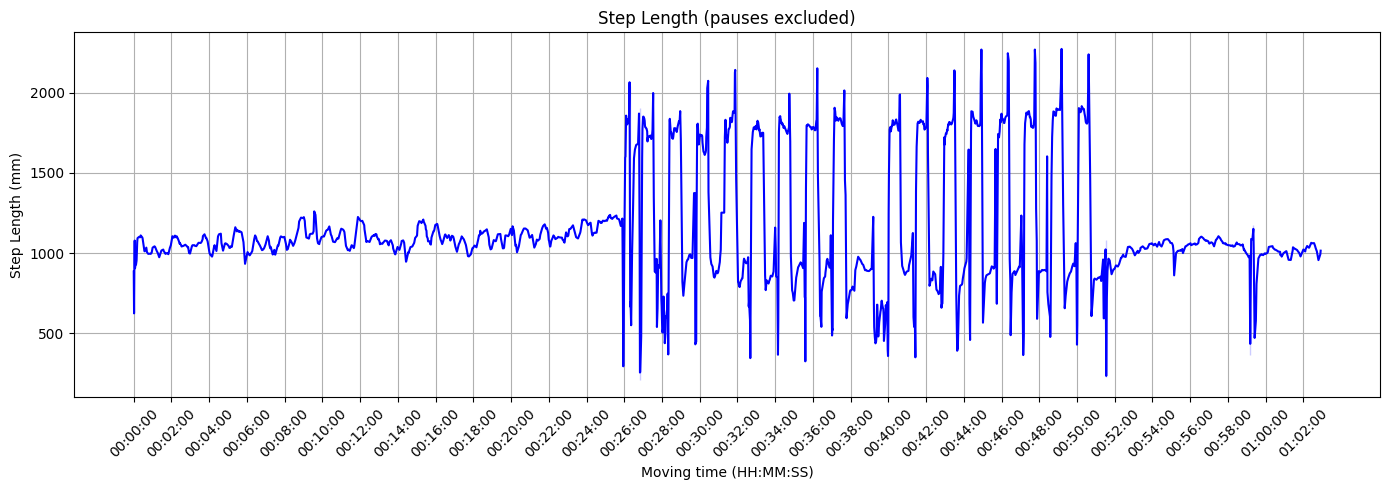

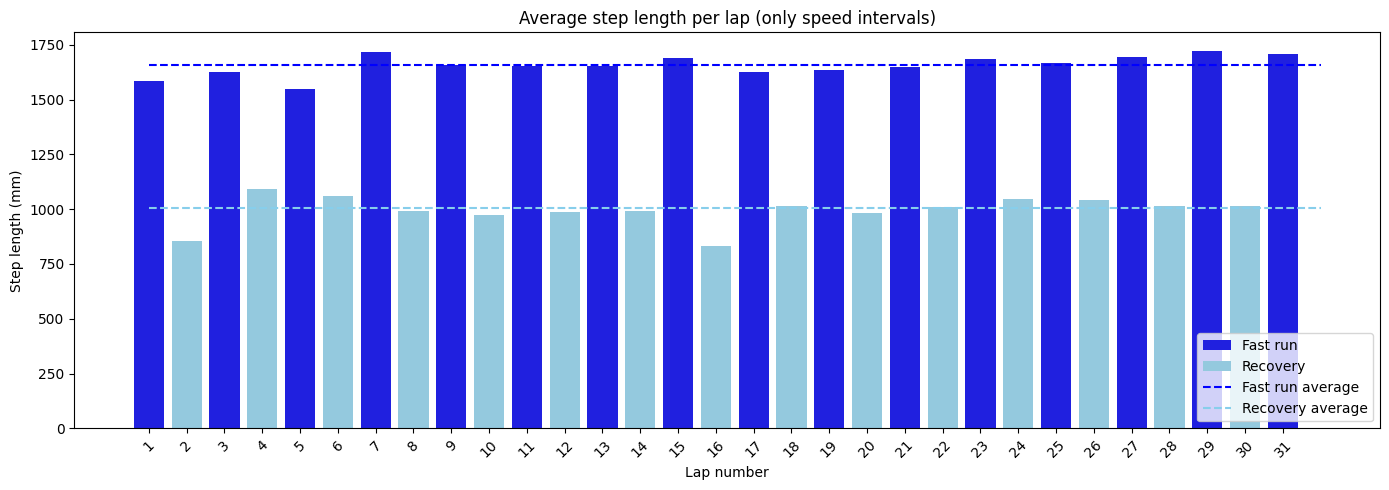

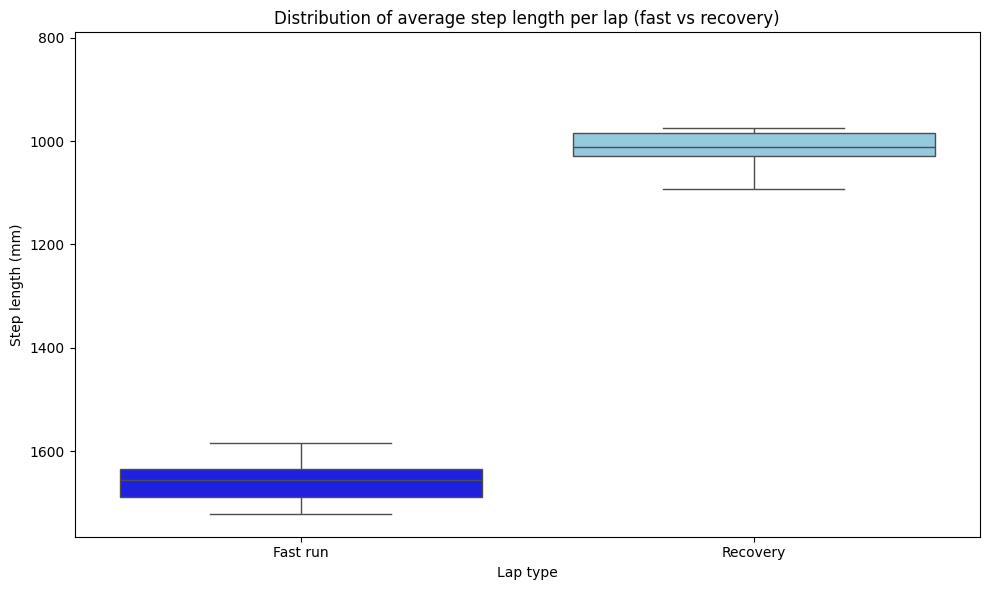

In [19]:
#Step Length

# -----------------------
# --- Lineplot ---
# -----------------------
plt.figure(figsize=(14,5))
ax = plt.gca()

sns.lineplot(x='time_moving_sec', y="step_length", data=df_plot_records, color='blue')

start = df_plot_records['time_moving_sec'].min()
end = df_plot_records['time_moving_sec'].max()
ticks = np.arange(start, end + 1, 120)
ax.xaxis.set_major_locator(FixedLocator(ticks))
ax.xaxis.set_major_formatter(FuncFormatter(sec_to_hhmmss))

plt.xlabel("Moving time (HH:MM:SS)")
plt.ylabel("Step Length (mm)")
plt.title("Step Length (pauses excluded)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

# -----------------------
# --- Barplot per lap ---
# -----------------------
plt.figure(figsize=(14,5))
ax = plt.gca()

sns.barplot(x=df_intervals.index + 1, 
            y='avg_step_length', 
            hue='type', 
            data=df_intervals, 
            palette=palette,
            dodge=False)

fast_avg_step_length = fast_laps['avg_step_length'].mean() 
slow_avg_step_length = slow_laps['avg_step_length'].mean() 

ax.hlines(fast_avg_step_length, xmin=xmin, xmax=xmax, 
          colors='blue', linestyles='--', label='Fast run average')
ax.hlines(slow_avg_step_length, xmin=xmin, xmax=xmax, 
          colors='skyblue', linestyles='--', label='Recovery average')

plt.xlabel("Lap number")
plt.ylabel("Step length (mm)")
plt.title("Average step length per lap (only speed intervals)")
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# -----------------------
# --- Boxplot per type ---
# -----------------------
plt.figure(figsize=(10,6))
ax = plt.gca()

sns.boxplot(x='type', y='avg_step_length', data=df_intervals,
            hue='type', palette=palette, dodge=False, fliersize=0)

ax.invert_yaxis()

plt.xlabel("Lap type")
plt.ylabel("Step length (mm)")
plt.title("Distribution of average step length per lap (fast vs recovery)")
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

**Analysis**
- There is a marked difference in step length between fast intervals and recovery intervals (first graph). There is a slight upward trend during the second half.
- Average step length per lap during fast intervals appears variable (between 1546 mm and 1721 mm).
- Average step length per lap during recovery intervals appears variable (between 856 mm and 1092 mm).

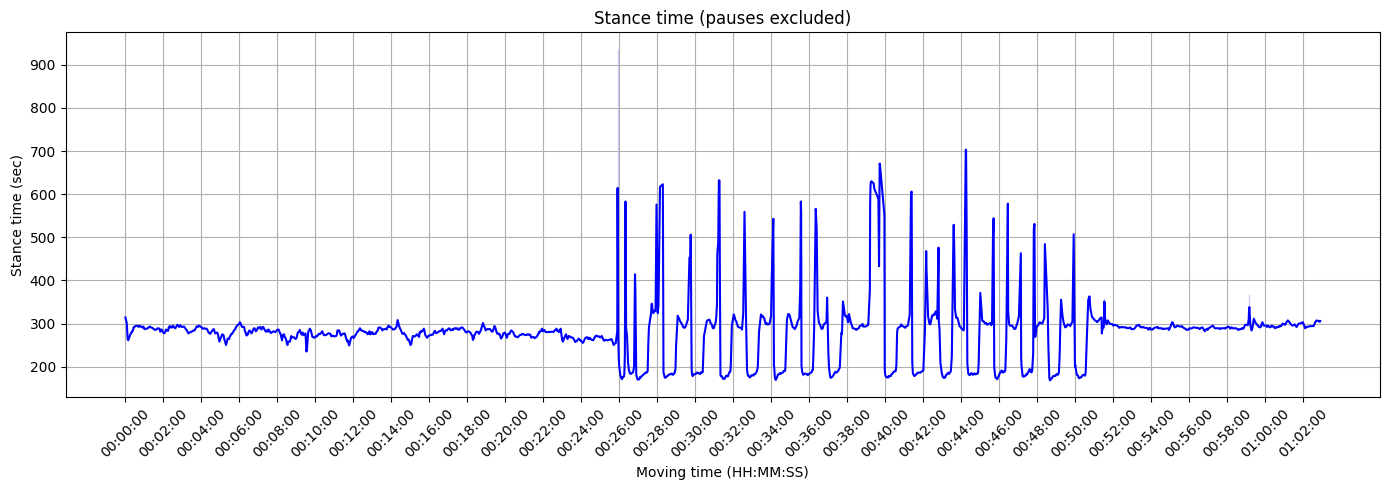

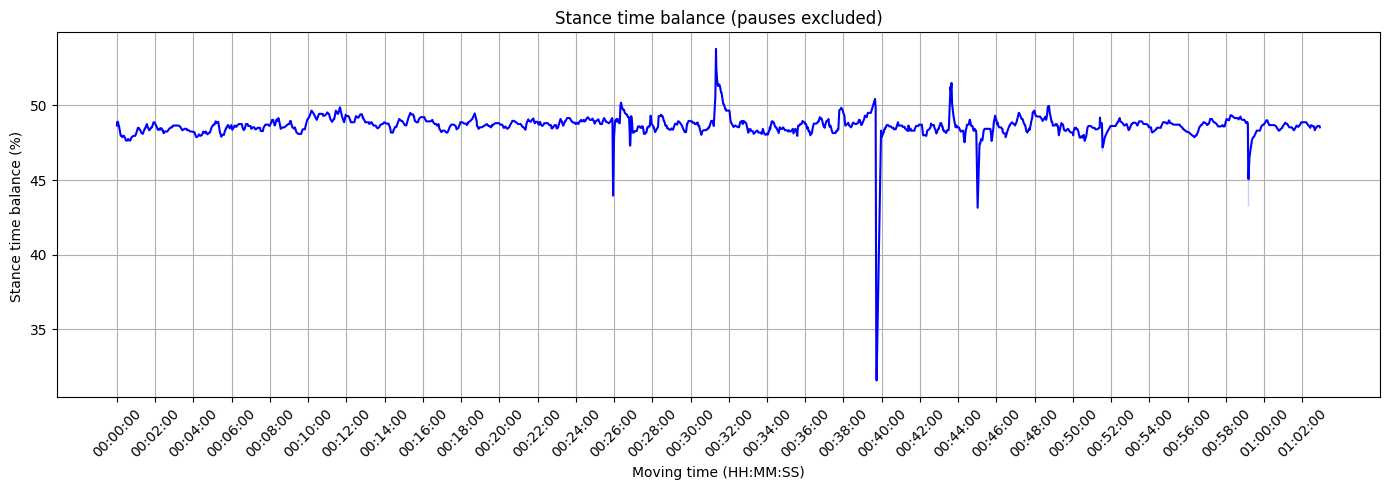

In [21]:
# Stance

# -----------------------
# --- Lineplot ---
# -----------------------
plt.figure(figsize=(14,5))
ax = plt.gca()

sns.lineplot(x='time_moving_sec', y="stance_time", data=df_plot_records, color='blue')

start = df_plot_records['time_moving_sec'].min()
end = df_plot_records['time_moving_sec'].max()
ticks = np.arange(start, end + 1, 120)
ax.xaxis.set_major_locator(FixedLocator(ticks))
ax.xaxis.set_major_formatter(FuncFormatter(sec_to_hhmmss))

plt.xlabel("Moving time (HH:MM:SS)")
plt.ylabel("Stance time (sec)")
plt.title("Stance time (pauses excluded)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

# -----------------------
# --- Lineplot ---
# -----------------------
plt.figure(figsize=(14,5))
ax = plt.gca()

sns.lineplot(x='time_moving_sec', y="stance_time_balance", data=df_plot_records, color='blue')

start = df_plot_records['time_moving_sec'].min()
end = df_plot_records['time_moving_sec'].max()
ticks = np.arange(start, end + 1, 120)
ax.xaxis.set_major_locator(FixedLocator(ticks))
ax.xaxis.set_major_formatter(FuncFormatter(sec_to_hhmmss))

plt.xlabel("Moving time (HH:MM:SS)")
plt.ylabel("Stance time balance (%) ")
plt.title("Stance time balance (pauses excluded)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()